## Convolutional Neural Network for Brain Tumor Detection and Diagnosis

### What is `Pytorch`?
PyTorch is an open-source **deep learning framework** developed by Meta AI that provides a flexible and dynamic platform for building and training neural networks. Known for its intuitive design and Pythonic interface, PyTorch allows developers to define models using dynamic computation graphs, making it easy to debug and modify models on the fly. It supports GPU acceleration, automatic differentiation through its `autograd` system, and a rich ecosystem including tools for **vision (TorchVision)**, text (TorchText), and deployment (TorchScript, ONNX). Widely used in both academic research and industry, PyTorch is praised for its readability, scalability, and strong community support.


In [ ]:
#!pip install split-folders
#!pip install torch-summary
#!pip install seaborn torch tqdm torchvision  scikit-learn
#!pip install ipywidgets --upgrade

In [1]:
import numpy as np 
import pandas as pd 
import matplotlib.pyplot as plt
import seaborn as sns; sns.set(style='darkgrid')
from sklearn.metrics import confusion_matrix, classification_report
import itertools # This import statement imports the itertools module, which provides functions for efficient looping and combining of iterables. It can be used for tasks such as generating combinations or permutations of elements.


In [2]:
import copy # A module that provides functions for creating copies of objects, useful for avoiding unintended modifications to variables.
import os # A module that provides a way to interact with the operating system, allowing for tasks such as file and directory manipulation.
import pathlib
import splitfolders
import warnings
warnings.filterwarnings('ignore')


In [3]:
# Import essential libraries
from PIL import Image # A module from the Python Imaging Library (PIL) that provides functionality for opening, manipulating, and saving various image file formats.

import torch
from torch import randint
from torch.optim.lr_scheduler import ReduceLROnPlateau # A PyTorch scheduler that adjusts the learning rate during training based on a specified metric, reducing it when the metric plateaus.
from torch.utils.data import DataLoader, Dataset, random_split

from torch import optim
import torch.nn as nn # A module in PyTorch that provides classes for defining and building neural networks.
import torch.nn.functional as F
from torchsummary import summary

import torchvision
from torchvision import utils # A module from torchvision that contains utility functions for working with images, such as saving and visualizing them.
from torchvision.datasets import ImageFolder
import torchvision.transforms as transforms # A module from the torchvision library that provides common image transformations, such as resizing, cropping, and normalization.

from tqdm.notebook import trange, tqdm # These functions allow for the creation of progress bars to track the progress of loops or tasks.

![](https://assets.neurosurgicalatlas.com/aaroncohen-gadol-com/patients/brain-tumor-fig1.jpg)

## Image fraud detection 
has proven to be highly effective in the field of medical imaging, where the integrity of images is critical for accurate diagnosis and treatment. With the increasing digitization of medical records and the use of AI-driven diagnostic tools, detecting tampered, manipulated, or synthetic images has become essential to ensure patient safety and uphold clinical standards. Advanced techniques, such as convolutional neural networks (CNNs), autoencoders, and image forensics algorithms, are employed to identify anomalies like copy-move forgeries, splicing, or deepfakes. These systems can detect subtle inconsistencies in pixel patterns, metadata, or compression artifacts that are often invisible to the human eye. By flagging suspicious images, image fraud detection not only helps prevent misdiagnosis and insurance fraud but also reinforces trust in digital healthcare systems.


Accurate detection and classification of **brain tumors** are vital for effective diagnosis and treatment planning. However, manually analyzing **medical images**, such as MRI scans, is often time-consuming, subjective, and prone to human error, potentially delaying critical care. This underscores the need for an automated, reliable system that can efficiently detect and classify brain tumors from medical images, supporting faster and more consistent clinical decision-making.

## Project Goal
This study aims to develop a Convolutional Neural Network **(CNN)** using the **PyTorch** framework to accurately detect and classify **brain tumors** from MRI scans. By training the model on a large dataset of labeled brain tumor images, the CNN will learn to recognize distinct patterns and features associated with various tumor types. The objective is to achieve high accuracy in both detection and classification, offering a powerful diagnostic aid for healthcare professionals in neuro-oncology. Ultimately, the goal is to enhance the speed and precision of brain tumor diagnosis, facilitating timely and effective treatment planning for patients.


## Dataset

In [4]:
labels_df = pd.read_csv('brain_tumor_metadata.csv')
if 'Unnamed: 0' in labels_df.columns:
    labels_df = labels_df.drop(columns=['Unnamed: 0'])
print(labels_df.shape)
labels_df

(4600, 5)


,image,class,format,mode,shape
0,Cancer (1).jpg,tumor,JPEG,RGB,"(512, 512, 3)"
1,Cancer (1).png,tumor,PNG,L,"(300, 240)"
2,Cancer (1).tif,tumor,TIFF,RGB,"(256, 256, 3)"
3,Cancer (10).jpg,tumor,JPEG,RGB,"(512, 512, 3)"
4,Cancer (10).tif,tumor,TIFF,RGB,"(256, 256, 3)"
...,...,...,...,...,...
4595,Not Cancer (995).jpg,normal,JPEG,RGB,"(168, 300, 3)"
4596,Not Cancer (996).jpg,normal,JPEG,RGB,"(509, 452, 3)"
4597,Not Cancer (997).jpg,normal,JPEG,RGB,"(197, 177, 3)"
4598,Not Cancer (998).jpg,normal,JPEG,RGB,"(217, 232, 3)"


The healthy scans and scans with brain tumors are divided into the following 2 folders. These are the labels we will use to create folders for our train and test data.

In [5]:
os.listdir('Brain Tumor Data Set')

['Brain Tumor', 'Healthy']

## Data preparation
We need to evaluate the model’s performance during training by using a validation dataset. To do this, we'll allocate **20%** of the data for the **validation set** and use the remaining **80%** for the **training set**, creating an effective **80/20 split** to monitor and optimize model performance.



#### Split into train and test

In [6]:
# Dataset Path
data_dir = 'Brain Tumor Data Set'
data_dir = pathlib.Path(data_dir)

directory_path = "train_test_splits"

if not os.path.exists(directory_path):
    os.makedirs(directory_path)  
    print(f"Directory '{directory_path}' created.")
else:
    print(f"Directory '{directory_path}' already exists.")


# Splitting dataset to train_set, val_set and test_set
splitfolders.ratio(data_dir, output=directory_path, seed=20, ratio=(0.8, 0.2))

Directory 'train_test_splits' already exists.


Copying files: 4600 files [00:49, 92.19 files/s] 


The folder structure is:

Brain Tumor Data Set/  
├── Brain Tumor/  
│   ├── Cancer (1)  
│   ├── Cancer (2)  
│   └── ...  
└── Healthy/  
    ├── Not Cancer (1)  
    ├── Not Cancer (2)  
    └── ...

After this line, you will get:

brian/  
├── train/  
│   ├── Brain Tumor/   
│   └── Healthy/   
└── val/  
    ├── Brain Tumor/    
    └── Healthy/ 


In [7]:
# New dataset path
data_dir = pathlib.Path(directory_path)

## Image Augmentation Definitions

Why is a sequence of image preprocessing and augmentation needed for modeling? Here are the reasons:

1. **Standardization & Consistency**
   Models require inputs of consistent size and format. Preprocessing steps like resizing and normalization ensure every image is the same size and pixel value scale, which helps the model learn efficiently without being confused by variations in input shape or intensity.

2. **Improved Model Generalization**
   Augmentation techniques (e.g., flipping, rotation) artificially increase the diversity of the training data by creating slightly modified versions of images. This helps the model generalize better to unseen data by exposing it to many variations of the same class, reducing overfitting.

3. **Normalization for Faster Convergence**
   Normalizing pixel values to a standard mean and standard deviation centers the data distribution. This improves numerical stability and speeds up training convergence because the model's weights receive inputs on a consistent scale.

4. **Data Augmentation to Mitigate Limited Data**
   Many datasets are limited in size. Augmentation artificially enlarges the dataset without needing more raw data, which is especially important in domains like medical imaging where data can be scarce or expensive to collect.

5. **Enabling Robust Feature Learning**
   By exposing the model to various transformations of the same image (rotated, flipped, etc.), the model learns to focus on invariant features — those that are meaningful regardless of image orientation or slight variations.

We will use `transforms` in `torchvision`.

In [8]:
# define transformation
transform = transforms.Compose(
    [
        transforms.Resize((256,256)),
        transforms.RandomHorizontalFlip(p=0.5),
        transforms.RandomVerticalFlip(p=0.5),
        transforms.RandomRotation(30),
        transforms.ToTensor(),
        transforms.Normalize(mean = [0.485, 0.456, 0.406],std = [0.229, 0.224, 0.225])
   ]
)

**Code explanations**

This code defines a sequence of image preprocessing and augmentation steps using PyTorch’s `transforms` module. These transformations are applied to images before feeding them into a neural network model. Here’s what each step does:

1. `transforms.Resize((256,256))`
   Resizes the input image to a fixed size of 256 pixels by 256 pixels. This ensures consistent input size for the model.

2. `transforms.RandomHorizontalFlip(p=0.5)`
   Randomly flips the image horizontally (left to right) with a 50% probability. This helps augment the dataset and make the model more robust to variations.

3. `transforms.RandomVerticalFlip(p=0.5)`
   Randomly flips the image vertically (top to bottom) with a 50% probability. This is another augmentation technique to increase data diversity.

4. `transforms.RandomRotation(30)`
   Rotates the image randomly within ±30 degrees. This introduces rotational variation to help the model generalize better.

5. `transforms.ToTensor()`
   Converts the image from a PIL Image or numpy array into a PyTorch tensor, and scales pixel values from \[0, 255] to \[0.0, 1.0].

6. `transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])`
   The values [0.485, 0.456, 0.406] and [0.229, 0.224, 0.225] are channel-wise means and standard deviations computed from the ImageNet training dataset. The code normalizes the image tensor by subtracting the mean and dividing by the standard deviation for each color channel (Red, Green, Blue). These values are standard normalization parameters used for pretrained models like ResNet to make the data distribution consistent.

In [9]:
# Define an object of the custom dataset for the train and validation.
train_set = torchvision.datasets.ImageFolder(data_dir.joinpath("train"), transform=transform) 
train_set.transform
val_set = torchvision.datasets.ImageFolder(data_dir.joinpath("val"), transform=transform)
val_set.transform

Compose(
    Resize(size=(256, 256), interpolation=bilinear, max_size=None, antialias=True)
    RandomHorizontalFlip(p=0.5)
    RandomVerticalFlip(p=0.5)
    RandomRotation(degrees=[-30.0, 30.0], interpolation=nearest, expand=False, fill=0)
    ToTensor()
    Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
)

**Code explanations**

- `torchvision.datasets.ImageFolder`:
  This is a PyTorch utility class that helps load image datasets stored in folders. It assumes that images are organized in a directory structure where each subfolder corresponds to a class label. For example:

  ```
  train/
    class1/
    class2/
  val/
    class1/
    class2/
  ```

- 
- `data_dir.joinpath("train")` and `data_dir.joinpath("val")`:
  These specify the directories containing training and validation images, respectively. `data_dir` is a `Path` object representing the base dataset folder, and `joinpath` appends the subfolder names `"train"` or `"val"` to it.

- `transform=transform`:
  This applies the sequence of image transformations (preprocessing and augmentations) defined earlier to each image as it is loaded. For example, resizing, flipping, normalization, etc.

- `train_set.transform` and `val_set.transform`:
  These are simply accessing the `transform` attribute of the dataset objects, showing which transformations will be applied to the images in those datasets.

#### Visualization some images from Train Set

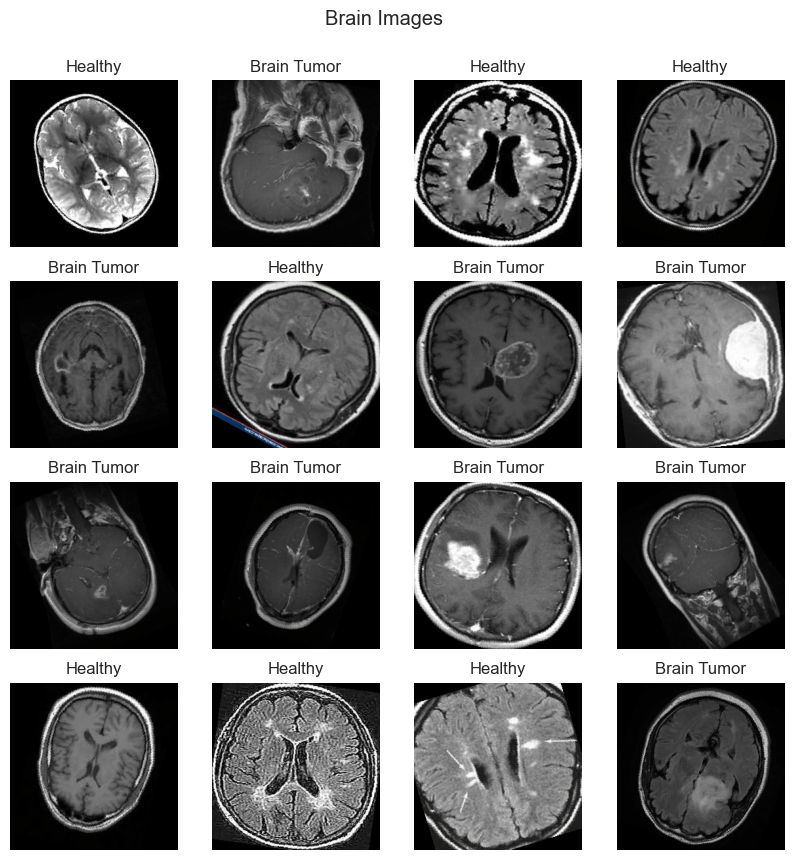

In [10]:
CLA_label = {
    0 : 'Brain Tumor',
    1 : 'Healthy'
} 

mean = np.array([0.485, 0.456, 0.406])
std  = np.array([0.229, 0.224, 0.225])

figure = plt.figure(figsize=(10, 10))
cols, rows = 4, 4
for i in range(1, cols * rows + 1):
    sample_idx = randint(len(train_set), size=(1,)).item()
    img, label = train_set[sample_idx]
    figure.add_subplot(rows, cols, i)
    plt.title(CLA_label[label])
    plt.axis("off")
    img_np = img.numpy().transpose((1, 2, 0))
    # Denormalize
    img_denorm = img_np * std + mean
    # Clip pixel values to [0, 1]
    img_valid_range = np.clip(img_denorm, 0, 1)
    plt.imshow(img_valid_range)
    plt.suptitle('Brain Images', y=0.95)
plt.show()

**Code explanation**

1. **`CLA_label` dictionary:**
   Maps numeric class labels (`0` and `1`) to human-readable class names — `'Brain Tumor'` and `'Healthy'`.

2. **`figure = plt.figure(figsize=(10, 10))`:**
   Creates a new matplotlib figure object with a size of 10x10 inches. This will hold the grid of images.

3. **`cols, rows = 4, 4`:**
   Sets up a grid with 4 columns and 4 rows, so a total of 16 images will be displayed.

4. **`for i in range(1, cols * rows + 1)`:**
   Loops from 1 to 16 (inclusive), for plotting each subplot image.

5. **`sample_idx = torch.randint(len(train_set), size=(1,)).item()`**
   Randomly selects an index within the range of the training dataset length. This picks a random image for display.

6. **`img, label = train_set[sample_idx]`**
   Retrieves the image tensor and its corresponding label from the dataset at the randomly chosen index.

7. **`figure.add_subplot(rows, cols, i)`**
   Adds a subplot to the figure in the ith position of the 4x4 grid.

8. **`plt.title(CLA_label[label])`**
   Sets the title of the subplot to the class name corresponding to the image label (either “Brain Tumor” or “Healthy”).

9. **`plt.axis("off")`**
   Hides the axis ticks and labels for a cleaner image display.

10. **`img_np = img.numpy().transpose((1, 2, 0))`**
    Converts the PyTorch tensor image (`C x H x W`) to a NumPy array and reorders its dimensions to `(H x W x C)`, which is the format matplotlib expects for displaying images.

11. **`img_valid_range = np.clip(img_np, 0, 1)`**
    Clips the pixel values to be within the valid range `[0, 1]` to ensure proper visualization (since normalized images may have values outside this range).

12. **`plt.imshow(img_valid_range)`**
    Displays the image in the subplot.

13. **`plt.suptitle('Brain Images', y=0.95)`**
    Adds a main title “Brain Images” at the top of the entire figure, slightly below the top edge.

14. **`plt.show()`**
    Renders and displays the figure with all 16 images arranged in the grid.

## Creating Dataloaders

In **PyTorch**, a **DataLoader** is a utility that helps efficiently load data in batches, shuffle it, and handle multiprocessing for faster training. It wraps around a dataset (usually a custom subclass of `torch.utils.data.Dataset`) and provides an iterable over the data, making it easy to feed inputs to a model during training or evaluation.

Key features of a `DataLoader` include:

* **Batching**: Automatically divides the dataset into mini-batches.
* **Shuffling**: Randomly shuffles the data at each epoch (useful for training).
* **Parallelism**: Loads data using multiple worker processes (`num_workers`) for faster throughput.
* **Custom sampling**: Allows control over the sampling strategy using custom `Sampler` classes.

In [11]:
# import and load train, validation
batch_size = 64
train_loader = DataLoader(train_set, batch_size = batch_size, shuffle = True, num_workers = 2)
val_loader = DataLoader(val_set, batch_size = batch_size, shuffle = True, num_workers = 2)

**Code explanation**: 

1. **`batch_size = 64`**
   This sets the number of samples that will be processed together in one forward/backward pass during training or validation. Using batches instead of single samples improves training efficiency and stability.

2. **`torch.utils.data.DataLoader`**
   The `DataLoader` is a PyTorch utility that creates an iterable over a dataset. It handles batching, shuffling, and parallel data loading automatically.

3. **`train_loader = torch.utils.data.DataLoader(train_set, batch_size=batch_size, shuffle=True, num_workers=2)`**

   * Loads data from the `train_set` dataset in batches of 64.
   * **`shuffle=True`**: Randomizes the order of data at each epoch to improve training robustness by preventing the model from seeing the data in the same order every time.
   * **`num_workers=2`**: Uses 2 subprocesses to load the data in parallel, speeding up the data loading process.

4. **`val_loader = torch.utils.data.DataLoader(val_set, batch_size=batch_size, shuffle=True, num_workers=2)`**

   * Similarly, this loads validation data in batches of 64 with shuffling and parallel loading.
   * Note: Sometimes, shuffling is set to `False` for validation since order doesn’t impact evaluation, but it’s not incorrect to shuffle validation data here.

#### Print shape for Training data and Validation data

In [14]:
print("X is a tensor with the following structure: (number of batches, number of channels (RGB), height of image, width of image)")
print("y is a vector whose length is the number of batches (64)\n")
for key, value in {'Training data': train_loader, "Validation data": val_loader}.items():
    for X, y in value:
        print(f"{key}:")
        print(f"Shape of X : {X.shape}")
        print(f"Shape of y: {y.shape} {y.dtype}\n")
        break

X is a tensor with the following structure: (number of batches, number of channels (RGB), height of image, width of image)
y is a vector whose length is the number of batches (64)

Training data:
Shape of X : torch.Size([64, 3, 256, 256])
Shape of y: torch.Size([64]) torch.int64

Validation data:
Shape of X : torch.Size([64, 3, 256, 256])
Shape of y: torch.Size([64]) torch.int64



## Define the Brain Tumor Model
- Define a function def `findConv2dOutShape()`
- Define a class `CNN_TUMOR()`

In [17]:
'''This function can be useful in determining the output size of a convolutional layer in a neural network,
given the input dimensions and the convolutional layer's parameters.'''
def findConv2dOutShape(hin,win,conv,pool=2):
    # get conv arguments
    kernel_size = conv.kernel_size
    stride=conv.stride
    padding=conv.padding
    dilation=conv.dilation

    hout=np.floor((hin+2*padding[0]-dilation[0]*(kernel_size[0]-1)-1)/stride[0]+1)
    wout=np.floor((win+2*padding[1]-dilation[1]*(kernel_size[1]-1)-1)/stride[1]+1)

    if pool:
        hout/=pool
        wout/=pool
    return int(hout),int(wout)

**2D Convolution Output Size**

$$
\text{out} = \left\lfloor \frac{\text{in} + 2p - d \, (k - 1) - 1}{s} + 1 \right\rfloor
$$

**Per dimension (height/width):**
$$
H_{\text{out}} = \left\lfloor \frac{H_{\text{in}} + 2p_h - d_h \, (k_h - 1) - 1}{s_h} + 1 \right\rfloor, \quad
W_{\text{out}} = \left\lfloor \frac{W_{\text{in}} + 2p_w - d_w \, (k_w - 1) - 1}{s_w} + 1 \right\rfloor
$$

**Where:**
- \(p\) (or \(p_h,p_w\)) = padding  
- \(d\) (or \(d_h,d_w\)) = dilation  
- \(k\) (or \(k_h,k_w\)) = kernel size  
- \(s\) (or \(s_h,s_w\)) = stride


**Code explanation**

This function calculates the spatial dimensions (height and width) of the output feature map after a 2D convolutional layer and optional pooling, given the input size and convolution parameters.

##### Parameters:

* **`hin`**: Input height (number of rows) of the image or feature map.
* **`win`**: Input width (number of columns).
* **`conv`**: A PyTorch convolutional layer object (e.g., `torch.nn.Conv2d`) from which the function extracts parameters like kernel size, stride, padding, and dilation.
* **`pool` (default=2)**: The size of the pooling operation to be applied after the convolution (e.g., 2 for 2x2 pooling). If `pool` is provided, output dimensions are further divided by this factor.

##### Steps:

1. **Extract convolution parameters:**

   * `kernel_size`: Size of the convolution filter (height, width).
   * `stride`: Step size of the convolution filter movement.
   * `padding`: Number of pixels added to each side of the input (height and width).
   * `dilation`: Spacing between kernel elements.

2. **Calculate output height (`hout`):**
   Uses the standard convolution output size formula:
$$
h_{\text{out}} = \left\lfloor 
\frac{h_{\text{in}} + 2 \times \text{padding} - \text{dilation} \times (\text{kernel\_size} - 1) - 1}
{\text{stride}} + 1 
\right\rfloor
$$

3. **Calculate output width (`wout`):**
   Same formula as height but applied to width.

4. **Adjust for pooling (if `pool` is specified):**
   Divides both `hout` and `wout` by the pooling size to reflect reduced spatial dimensions after pooling.


### Define Architecture For CNN_TUMOR Model

In [15]:
# Define Architecture For CNN_TUMOR Model
class CNN_TUMOR(nn.Module):
    
    # Network Initialisation
    def __init__(self, params):
        
        super(CNN_TUMOR, self).__init__()
    
        Cin,Hin,Win = params["shape_in"]
        init_f = params["initial_filters"] 
        num_fc1 = params["num_fc1"]  
        num_classes = params["num_classes"] 
        self.dropout_rate = params["dropout_rate"] 
        
        # Convolution Layers
        self.conv1 = nn.Conv2d(Cin, init_f, kernel_size=3)  # first conv layer with 8 filters (see params below)
        h,w=findConv2dOutShape(Hin,Win,self.conv1)
        self.conv2 = nn.Conv2d(init_f, 2*init_f, kernel_size=3) # 2*8 filters
        h,w=findConv2dOutShape(h,w,self.conv2)
        self.conv3 = nn.Conv2d(2*init_f, 4*init_f, kernel_size=3) # 4*8 output filters
        h,w=findConv2dOutShape(h,w,self.conv3)
        self.conv4 = nn.Conv2d(4*init_f, 8*init_f, kernel_size=3) # 8*8 output filters
        h,w=findConv2dOutShape(h,w,self.conv4)
        
        # compute the flatten size
        self.num_flatten=h*w*8*init_f
        self.fc1 = nn.Linear(self.num_flatten, num_fc1)
        self.fc2 = nn.Linear(num_fc1, num_classes)

    def forward(self,X):
        
        # Convolution & Pool Layers
        X = F.relu(self.conv1(X)); 
        X = F.max_pool2d(X, 2, 2)  # kernel=2 (2x2 window), stride=2 (move the window 2 units at a time)
        X = F.relu(self.conv2(X))
        X = F.max_pool2d(X, 2, 2)
        X = F.relu(self.conv3(X))
        X = F.max_pool2d(X, 2, 2)
        X = F.relu(self.conv4(X))
        X = F.max_pool2d(X, 2, 2)
        X = X.view(-1, self.num_flatten)
        X = F.relu(self.fc1(X))
        X = F.dropout(X, self.dropout_rate)
        X = self.fc2(X)
        return F.log_softmax(X, dim=1)

**Code explanation**

```python
class CNN_TUMOR(nn.Module):
```

This creates a new class `CNN_TUMOR` that inherits from `torch.nn.Module`, which is the base class for all neural network models in PyTorch.

```python
def __init__(self, params):
    super(CNN_TUMOR, self).__init__()
```

This constructor initializes the CNN using a dictionary of parameters (`params`), and sets up the layers of the network.

```python
Cin, Hin, Win = params["shape_in"]
init_f = params["initial_filters"]
num_fc1 = params["num_fc1"]
num_classes = params["num_classes"]
self.dropout_rate = params["dropout_rate"]
```

* `shape_in`: Input image dimensions: channels, height, and width.
* `initial_filters`: Number of filters in the first convolutional layer.
* `num_fc1`: Number of units in the first fully connected (dense) layer.
* `num_classes`: Number of output classes (e.g., 2 $-$ tumor vs. healthy).
* `dropout_rate`: Dropout rate used to prevent overfitting.

```python
self.conv1 = nn.Conv2d(Cin, init_f, kernel_size=3)
h, w = findConv2dOutShape(Hin, Win, self.conv1)
```

This defines the first convolutional layer and uses a helper function `findConv2dOutShape` to compute the output height and width after convolution and pooling. This is repeated with increased filter depth for deeper layers:

```python
self.conv2 = nn.Conv2d(init_f, 2*init_f, kernel_size=3)
self.conv3 = nn.Conv2d(2*init_f, 4*init_f, kernel_size=3)
self.conv4 = nn.Conv2d(4*init_f, 8*init_f, kernel_size=3)
```

Fully Connected Layers

```python
self.num_flatten = h * w * 8 * init_f
self.fc1 = nn.Linear(self.num_flatten, num_fc1)
self.fc2 = nn.Linear(num_fc1, num_classes)
```

* After the conv layers, the image is flattened into a 1D vector with `self.num_flatten` elements.
* `fc1` maps this vector to a smaller hidden layer.
* `fc2` produces the final output corresponding to class scores.


**Define Forward Pass**

```python
def forward(self, X):
```

This function defines how the input data (`X`) flows through the network.

```python
X = F.relu(self.conv1(X))
X = F.max_pool2d(X, 2, 2)
```

* Applies convolution → ReLU activation → 2x2 max pooling.
* This pattern is repeated for all conv layers:

```python
X = F.relu(self.conv2(X))
X = F.max_pool2d(X, 2, 2)
X = F.relu(self.conv3(X))
X = F.max_pool2d(X, 2, 2)
X = F.relu(self.conv4(X))
X = F.max_pool2d(X, 2, 2)
```

Flatten and Classify:

```python
X = X.view(-1, self.num_flatten)       # Flatten the tensor
X = F.relu(self.fc1(X))                # Fully connected layer + ReLU
X = F.dropout(X, self.dropout_rate)    # Apply dropout
X = self.fc2(X)                        # Final output layer
return F.log_softmax(X, dim=1)         # Log-softmax for class probabilities
```

## Define the Model Training
- The Hyperparameters for model training
- The loss function
- The optimiser

In [18]:
params_model={
        "shape_in": (3,256,256), 
        "initial_filters": 8,    
        "num_fc1": 100,
        "dropout_rate": 0.25,
        "num_classes": 2}

# Create instantiation of Network class
cnn_model = CNN_TUMOR(params_model)

# define computation hardware approach (GPU/CPU)
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model = cnn_model.to(device)

**Code explanation**

```python
params_model = {
    "shape_in": (3, 256, 256), 
    "initial_filters": 8,    
    "num_fc1": 100,
    "dropout_rate": 0.25,
    "num_classes": 2
}
```

This dictionary defines **hyperparameters** for your CNN model:

* `"shape_in": (3, 256, 256)`
  → The input image shape: 3 channels (RGB), height = 256, width = 256.

* `"initial_filters": 8`
  → The first convolutional layer will have 8 filters. Subsequent layers will increase this (e.g., 16, 32, 64).

* `"num_fc1": 100`
  → The first fully connected (dense) layer will have 100 neurons.

* `"dropout_rate": 0.25`
  → 25% of neurons will be randomly dropped during training to reduce overfitting.

* `"num_classes": 2`
  → The output layer will classify images into 2 categories: e.g., `tumor` and `healthy`.

```python
# Create instantiation of Network class
cnn_model = CNN_TUMOR(params_model)
```

This creates an instance of the `CNN_TUMOR` class (your custom CNN architecture), initialized with the parameters defined in `params_model`.


```python
# define computation hardware approach (GPU/CPU)
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
```

* Checks if a **CUDA-capable GPU** is available.
* If yes, sets the computation device to `"cuda"` (use GPU).
* If no, sets it to `"cpu"`.

This is important because running deep learning models on a GPU significantly speeds up training and inference.


```python
model = cnn_model.to(device)
```

Moves the model (i.e., all its weights and structure) to the selected computation device (`GPU` or `CPU`).
This ensures that all model operations (forward pass, backpropagation, etc.) happen on the same device.

In [19]:
# Model Summary for CNN Model
summary(cnn_model, input_size=(3, 256, 256),device=device.type)

Layer (type:depth-idx)                   Param #
├─Conv2d: 1-1                            224
├─Conv2d: 1-2                            1,168
├─Conv2d: 1-3                            4,640
├─Conv2d: 1-4                            18,496
├─Linear: 1-5                            1,254,500
├─Linear: 1-6                            202
Total params: 1,279,230
Trainable params: 1,279,230
Non-trainable params: 0


Layer (type:depth-idx)                   Param #
├─Conv2d: 1-1                            224
├─Conv2d: 1-2                            1,168
├─Conv2d: 1-3                            4,640
├─Conv2d: 1-4                            18,496
├─Linear: 1-5                            1,254,500
├─Linear: 1-6                            202
Total params: 1,279,230
Trainable params: 1,279,230
Non-trainable params: 0

### Define the Loss Function

In [20]:
loss_func = nn.NLLLoss(reduction="mean")

**Code explanation**

This line **creates a loss function** called **Negative Log Likelihood Loss (NLLLoss)** from PyTorch’s `nn` module and assigns it to the variable `loss_func`.


- `nn.NLLLoss()`

This stands for **Negative Log Likelihood Loss**, commonly used for **classification tasks** where the model outputs log-probabilities (usually via `log_softmax`).
* It **compares the predicted log-probabilities** of each class with the true class labels.
* Best used **in combination with `F.log_softmax`** in the final layer of your model.

- `NLLLoss` expects the model output to be in **log-probability format** (not raw logits or probabilities).

- `reduction="sum"`

Controls **how the loss is aggregated across the batch**:

  * `"mean"` → Average loss across all samples (default)
  * `"sum"` → Adds up the loss across all samples
  * `"none"` → Returns the loss for each individual sample


Here it means the final loss value will be the **sum of individual losses** across the batch. This is useful when you want to later normalize by the number of samples manually (e.g., for custom learning rate scaling or weighted loss).

### Define the Optimizer

In [21]:
from torch.optim import Adam
from torch.optim.lr_scheduler import ReduceLROnPlateau

optimizer = Adam(model.parameters(), lr=3e-4)
scheduler = ReduceLROnPlateau(optimizer, mode='min', factor=0.5, patience=10) #, verbose=True)


**Code explanation**

- `from torch.optim import Adam`

This imports the **Adam optimizer** from PyTorch. Adam is an adaptive gradient descent optimization algorithm that works well for training deep learning models. It combines the benefits of AdaGrad and RMSProp.

- `from torch.optim.lr_scheduler import ReduceLROnPlateau`

This imports a **learning rate scheduler** that monitors a validation metric and reduces the learning rate **when the metric has stopped improving**. It's useful for fine-tuning model training.

Creates an Adam optimizer with:

* `model.parameters()` → the model's learnable weights
* `lr=3e-4` → learning rate is set to 0.0003

- `optimizer = Adam(model.parameters(), lr=3e-4)`

This assigns the optimizer to a variable named `optimizer`.

- `scheduler = ReduceLROnPlateau(...)`

This creates a **learning rate scheduler** that will monitor a validation metric (e.g., validation loss), and if it **doesn’t improve for a while**, the scheduler will reduce the learning rate.

- Parameters:

* `optimizer`: the optimizer to modify (here, the Adam optimizer).
* `mode='min'`: the scheduler looks for **a decrease** in the monitored value (e.g., you use this for minimizing validation loss).
* `factor=0.5`: when triggered, the learning rate is **multiplied by 0.5** (i.e., cut in half).
* `patience=10`: if there’s **no improvement for 10 consecutive checks**, reduce the learning rate.

You typically call `scheduler.step(validation_loss)` inside your training loop to monitor how the model is doing on the validation set.


In [22]:
import torch.optim.lr_scheduler as lrsched
print(lrsched.ReduceLROnPlateau.__module__)

torch.optim.lr_scheduler


## Training Model

In [23]:
# Function to get the learning rate
def get_lr(opt):
    for param_group in opt.param_groups:
        return param_group['lr']

# Function to compute the loss value per batch of data
def loss_batch(loss_func, output, target, opt=None):
    
    loss = loss_func(output, target) # get loss
    pred = output.argmax(dim=1, keepdim=True) # Get Output Class
    metric_b=pred.eq(target.view_as(pred)).sum().item() # get performance metric
    
    if opt is not None:
        opt.zero_grad()
        loss.backward()
        opt.step()

    return loss.item(), metric_b

# Compute the loss value & performance metric for the entire dataset (epoch)
def loss_epoch(model,loss_func,dataset_dl,opt=None):
    
    run_loss=0.0 
    t_metric=0.0
    len_data=len(dataset_dl.dataset)

    # internal loop over dataset
    for xb, yb in dataset_dl:
        # move batch to device
        xb=xb.to(device)
        yb=yb.to(device)
        output=model(xb) # get model output
        loss_b,metric_b=loss_batch(loss_func, output, yb, opt) # get loss per batch
        run_loss+=loss_b        # update running loss

        if metric_b is not None: # update running metric
            t_metric+=metric_b    
    
    loss=run_loss/float(len_data)  # average loss value
    metric=t_metric/float(len_data) # average metric value
    
    return loss, metric

**Code explanation**

1. **Get the Learning Rate**

```python
def get_lr(opt):
    for param_group in opt.param_groups:
        return param_group['lr']
```

This function returns the current learning rate being used by the optimizer `opt`. In PyTorch, optimizers can have different parameter groups with different learning rates. This function grabs the learning rate from the first group (usually the only one). It’s commonly used for logging or debugging during training.

2. **Compute Loss and Accuracy for a Single Batch**

```python
def loss_batch(loss_func, output, target, opt=None):
    loss = loss_func(output, target)
    pred = output.argmax(dim=1, keepdim=True)
    metric_b = pred.eq(target.view_as(pred)).sum().item()

    if opt is not None:
        opt.zero_grad()
        loss.backward()
        opt.step()

    return loss.item(), metric_b
```

* Computes **loss** and **number of correct predictions** (`metric_b`) for one batch.
* If an optimizer is provided (`opt is not None`), it performs a **training step**:

  1. Zeros gradients
  2. Backpropagates
  3. Updates model parameters with `opt.step()`

* `pred = output.argmax(...)`: Gets predicted class with highest log-probability.
* `metric_b = ...`: Compares predictions with true labels and counts how many are correct.

3. Compute Loss and Accuracy for an Entire Epoch

```python
def loss_epoch(model, loss_func, dataset_dl, opt=None):
    run_loss = 0.0 
    t_metric = 0.0
    len_data = len(dataset_dl.dataset)

    for xb, yb in dataset_dl:
        xb = xb.to(device)
        yb = yb.to(device)
        output = model(xb)
        loss_b, metric_b = loss_batch(loss_func, output, yb, opt)
        run_loss += loss_b
        if metric_b is not None:
            t_metric += metric_b    
    
    loss = run_loss / float(len_data)
    metric = t_metric / float(len_data)
    
    return loss, metric
```

* Loops through the **entire dataset** (`dataset_dl`) in batches.
* Computes **total loss and accuracy** over all batches.
* Averages the results to return:

  * `loss`: average loss per sample
  * `metric`: accuracy (fraction of correct predictions)

4. Behavior:

* If `opt` is passed → model trains (via backprop).
* If `opt` is `None` → model evaluates (no gradient updates).

5. Summary Table:

| Function       | Purpose                                                                   |
| -------------- | ------------------------------------------------------------------------- |
| `get_lr()`     | Returns current learning rate from optimizer                              |
| `loss_batch()` | Computes loss and correct predictions for 1 batch (and optionally trains) |
| `loss_epoch()` | Evaluates entire epoch over dataset (train or eval)                       |

## Training Function

In [24]:
def Train_Val(model, params,verbose=False):
    
    # Get the parameters
    epochs=params["epochs"]
    loss_func=params["f_loss"]
    opt=params["optimizer"]
    train_dl=params["train"]
    val_dl=params["val"]
    lr_scheduler=params["lr_change"]
    weight_path=params["weight_path"]
    
    # history of loss values in each epoch
    loss_history={"train": [],"val": []} 
    # histroy of metric values in each epoch
    metric_history={"train": [],"val": []} 
    # a deep copy of weights for the best performing model
    best_model_wts = copy.deepcopy(model.state_dict()) 
    # initialize best loss to a large value
    best_loss=float('inf') 

# Train Model n_epochs (the progress of training by printing the epoch number and the associated learning rate. It can be helpful for debugging, monitoring the learning rate schedule, or gaining insights into the training process.) 
    
    for epoch in tqdm(range(epochs)):
        
        # Get the Learning Rate
        current_lr=get_lr(opt)
        if(verbose):
            print('Epoch {}/{}, current lr={}'.format(epoch, epochs - 1, current_lr))

        
# Train Model Process

        
        model.train()
        train_loss, train_metric = loss_epoch(model,loss_func,train_dl,opt)

        # collect losses
        loss_history["train"].append(train_loss)
        metric_history["train"].append(train_metric)
        

# Evaluate Model Process

        
        model.eval()
        with torch.no_grad():
            val_loss, val_metric = loss_epoch(model,loss_func,val_dl)
        
        # store best model
        if(val_loss < best_loss):
            best_loss = val_loss
            best_model_wts = copy.deepcopy(model.state_dict())
            
            # store weights into a local file
            torch.save(model.state_dict(), weight_path)
            if(verbose):
                print("Copied best model weights!")
        
        # collect loss and metric for validation dataset
        loss_history["val"].append(val_loss)
        metric_history["val"].append(val_metric)
        
        # learning rate schedule
        lr_scheduler.step(val_loss)
        if current_lr != get_lr(opt):
            if(verbose):
                print("Loading best model weights!")
            model.load_state_dict(best_model_wts) 

        if(verbose):
            print(f"train loss: {train_loss:.6f}, dev loss: {val_loss:.6f}, accuracy: {100*val_metric:.2f}")
            print("-"*10) 

    # load best model weights
    model.load_state_dict(best_model_wts)
        
    return model, loss_history, metric_history

**Code explanation**

```python
def Train_Val(model, params, verbose=False):
```

This function trains and evaluates a PyTorch model using the specified training parameters. It tracks performance over epochs and saves the best-performing model based on validation loss.

---

* **`model`**: the PyTorch model to train.
* **`params`**: a dictionary containing:

  * `"epochs"`: number of epochs to train
  * `"f_loss"`: loss function (e.g., `nn.NLLLoss`)
  * `"optimizer"`: optimizer (e.g., Adam)
  * `"train"`: training dataloader
  * `"val"`: validation dataloader
  * `"lr_change"`: learning rate scheduler (e.g., `ReduceLROnPlateau`)
  * `"weight_path"`: path to save the best model weights
* **`verbose`**: if `True`, prints logs during training

---

1. Initialization

```python
loss_history = {"train": [], "val": []}
metric_history = {"train": [], "val": []}
best_model_wts = copy.deepcopy(model.state_dict())
best_loss = float('inf')
```

* **Tracks loss and accuracy** (metric) for each epoch.
* **Stores a deep copy** of the model weights that achieve the best validation loss.
* `best_loss` is initialized to a very high number so that any real loss will be better.

2. Epoch Loop

```python
for epoch in tqdm(range(epochs)):
```

The model is trained and evaluated for each epoch, and training progress is displayed with `tqdm`.

3. Get Current Learning Rate

```python
current_lr = get_lr(opt)
```

Tracks learning rate from the optimizer for logging and learning rate adjustment.


4. Training Phase

```python
model.train()
train_loss, train_metric = loss_epoch(model, loss_func, train_dl, opt)
```

* Sets the model to **training mode**.
* Uses `loss_epoch` to run through the **entire training set**, computing loss and accuracy.
* Performs backpropagation and weight updates.

5. Validation Phase

```python
model.eval()
with torch.no_grad():
    val_loss, val_metric = loss_epoch(model, loss_func, val_dl)
```

* Sets the model to **evaluation mode**.
* Turns off gradient computation to save memory and speed up validation.

6. Save Best Model

```python
if(val_loss < best_loss):
    best_loss = val_loss
    best_model_wts = copy.deepcopy(model.state_dict())
    torch.save(model.state_dict(), weight_path)
```

* If current validation loss is better than previous best, save the model weights to memory **and to a file** (`weight_path`).

7. Learning Rate Adjustment

```python
lr_scheduler.step(val_loss)
if current_lr != get_lr(opt):
    model.load_state_dict(best_model_wts)
```

* Updates the learning rate based on validation loss using the scheduler.
* If the learning rate was adjusted, the model is reset to its best weights to avoid overfitting or divergence.

8. Logging

```python
if verbose:
    print(f"train loss: {train_loss:.6f}, dev loss: {val_loss:.6f}, accuracy: {100*val_metric:.2f}")
```

* If `verbose=True`, logs training and validation performance each epoch.

9. Final Step: Load Best Model

```python
model.load_state_dict(best_model_wts)
```

After training, the model is reset to the weights that gave the **lowest validation loss**.

10. Returns:

```python
return model, loss_history, metric_history
```

* **`model`**: the trained model (with best weights)
* **`loss_history`**: dictionary of training/validation loss per epoch
* **`metric_history`**: dictionary of training/validation accuracy per epoch

## Training Process

In [25]:
import time

# Start timing
start_time = time.perf_counter()

# Define various parameters used for training and evaluation of a cnn_model
# Training parameters
params_train = {
    "train": train_loader,
    "val": val_loader,
    "epochs": 60,
    "optimizer": optim.Adam(cnn_model.parameters(), lr=3e-4),
    "lr_change": ReduceLROnPlateau(
        optimizer,
        mode='min',
        factor=0.5,
        patience=20
    ),
    "f_loss": nn.NLLLoss(reduction="sum"),
    "weight_path": "weights.pt",
}

# Train and validate the model
cnn_model, loss_hist, metric_hist = Train_Val(cnn_model, params_train)

# End timing
end_time = time.perf_counter()

# Compute elapsed time in minutes
elapsed_min = round((end_time - start_time) / 60)

print(f"Training completed in approximately {elapsed_min} minute(s).")

  0%|          | 0/60 [00:00<?, ?it/s]

Training completed in approximately 19 minute(s).


**Code explanation**

1. `params_train`: Dictionary of Training Parameters

```python
params_train = {
  "train": train_loader,
  "val": val_loader,
  "epochs": 60,
  "optimizer": optim.Adam(cnn_model.parameters(), lr=3e-4),
  "lr_change": ReduceLROnPlateau(opt,
                                 mode='min',
                                 factor=0.5,
                                 patience=20),
  "f_loss": nn.NLLLoss(reduction="sum"),
  "weight_path": "weights.pt",
}
```

| Key             | Description                                                                                                                              |
| --------------- | ---------------------------------------------------------------------------------------------------------------------------------------- |
| `"train"`       | The **training data loader** (`train_loader`), which batches and feeds the training data.                                                |
| `"val"`         | The **validation data loader** (`val_loader`) for evaluating performance after each epoch.                                               |
| `"epochs"`      | The number of epochs to train the model (60 here).                                                                                       |
| `"optimizer"`   | The **optimizer** used to update model weights — here, Adam with a learning rate of `3e-4`.                                              |
| `"lr_change"`   | A **learning rate scheduler** (`ReduceLROnPlateau`) that reduces the learning rate if validation loss plateaus.                          |
| `"f_loss"`      | The **loss function** used during training — `NLLLoss` (Negative Log Likelihood), suitable when using `log_softmax` in the model output. |
| `"weight_path"` | Path where the best model weights will be saved (`weights.pt`).                                                                          |

3. Training the Model

```python
cnn_model, loss_hist, metric_hist = Train_Val(cnn_model, params_train)
```

* Calls the `Train_Val` function with the CNN model and `params_train`.
* The model is trained for 60 epochs using the specified loss function, optimizer, learning rate scheduler, etc.
* The **best model weights (lowest validation loss)** are saved to `"weights.pt"`.

4. Returned:

* `cnn_model`: the trained model with best-performing weights loaded.
* `loss_hist`: dictionary tracking training/validation loss per epoch.
* `metric_hist`: dictionary tracking training/validation accuracy per epoch.

## Evaluation Metric Visualization

<Axes: >

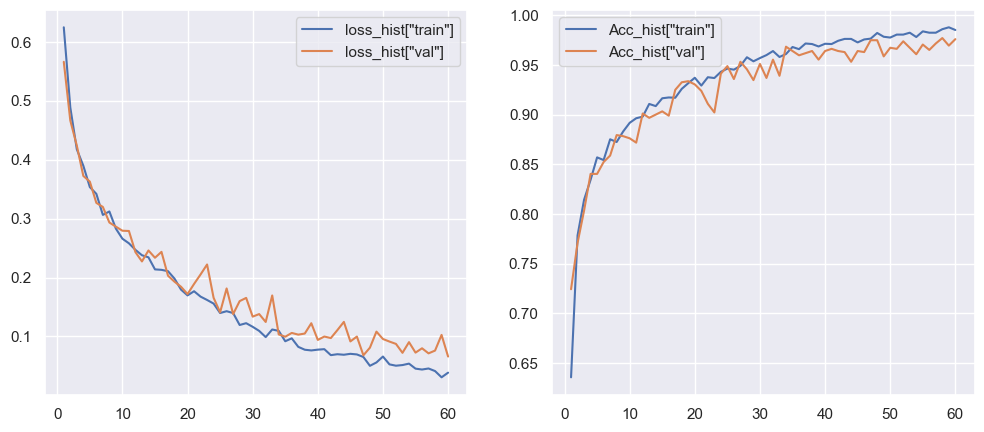

In [26]:
# Convergence History Plot
epochs=params_train["epochs"]
fig,ax = plt.subplots(1,2,figsize=(12,5))

sns.lineplot(x=[*range(1,epochs+1)],y=loss_hist["train"],ax=ax[0],label='loss_hist["train"]')
sns.lineplot(x=[*range(1,epochs+1)],y=loss_hist["val"],ax=ax[0],label='loss_hist["val"]')
sns.lineplot(x=[*range(1,epochs+1)],y=metric_hist["train"],ax=ax[1],label='Acc_hist["train"]')
sns.lineplot(x=[*range(1,epochs+1)],y=metric_hist["val"],ax=ax[1],label='Acc_hist["val"]')

**Code explanation**

1. Step 1: Get the number of epochs

```python
epochs = params_train["epochs"]
```

* Retrieves the total number of training epochs (e.g., `60`) from your training parameters dictionary.
* This determines the **x-axis range** for the plots.

2. Step 2: Create subplots

```python
fig, ax = plt.subplots(1, 2, figsize=(12, 5))
```

* Creates a **figure with 2 side-by-side subplots** (`ax[0]` and `ax[1]`).
* The figure size is 12 inches wide × 5 inches tall.
* These will be used for:

  * `ax[0]`: loss over epochs
  * `ax[1]`: accuracy over epochs

3. Step 3: Plot training & validation loss

```python
sns.lineplot(x=[*range(1, epochs+1)], y=loss_hist["train"], ax=ax[0], label='loss_hist["train"]')
sns.lineplot(x=[*range(1, epochs+1)], y=loss_hist["val"], ax=ax[0], label='loss_hist["val"]')
```

* Uses **Seaborn's lineplot** to draw curves of loss values.
* `x = [1, 2, ..., epochs]`: x-axis is epoch number.
* `y = loss_hist["train"]` and `loss_hist["val"]`: y-axis is training and validation loss.
* `ax=ax[0]`: plots on the first subplot.
* `label=...`: adds labels for the legend.

4. Step 4: Plot training & validation accuracy

```python
sns.lineplot(x=[*range(1, epochs+1)], y=metric_hist["train"], ax=ax[1], label='Acc_hist["train"]')
sns.lineplot(x=[*range(1, epochs+1)], y=metric_hist["val"], ax=ax[1], label='Acc_hist["val"]')
```

* Same as above, but for accuracy (or whatever metric you tracked in `metric_hist`).
* Plots on `ax[1]`, the second subplot.
* These curves show how **classification performance** improved during training.

This code produces two plots side-by-side:

1. **Loss Plot (left)**:

   * Shows how the training and validation loss changed over epochs.
   * Helps you identify **underfitting**, **overfitting**, or **good convergence**.

2. **Accuracy Plot (right)**:

   * Displays how training and validation accuracy evolved.
   * Useful for diagnosing if the model is **learning generalizable patterns** or just memorizing training data.

## Confusion_Matrix

In [27]:
# define function For Classification Report
def True_and_Pred(val_loader, model):
    i = 0
    y_true = []
    y_pred = []
    for images, labels in val_loader:
        images = images.to(device)
        labels = labels.numpy()
        outputs = model(images)
        _, pred = torch.max(outputs.data, 1)
        pred = pred.detach().cpu().numpy()
        
        y_true = np.append(y_true, labels)
        y_pred = np.append(y_pred, pred)
    
    return y_true, y_pred


# check confusion matrix for error analysis
y_true, y_pred = True_and_Pred(val_loader, cnn_model)

print(classification_report(y_true, y_pred), '\n\n')
cm = confusion_matrix(y_true, y_pred)

              precision    recall  f1-score   support

         0.0       0.98      0.96      0.97       503
         1.0       0.96      0.97      0.97       418

    accuracy                           0.97       921
   macro avg       0.97      0.97      0.97       921
weighted avg       0.97      0.97      0.97       921
 




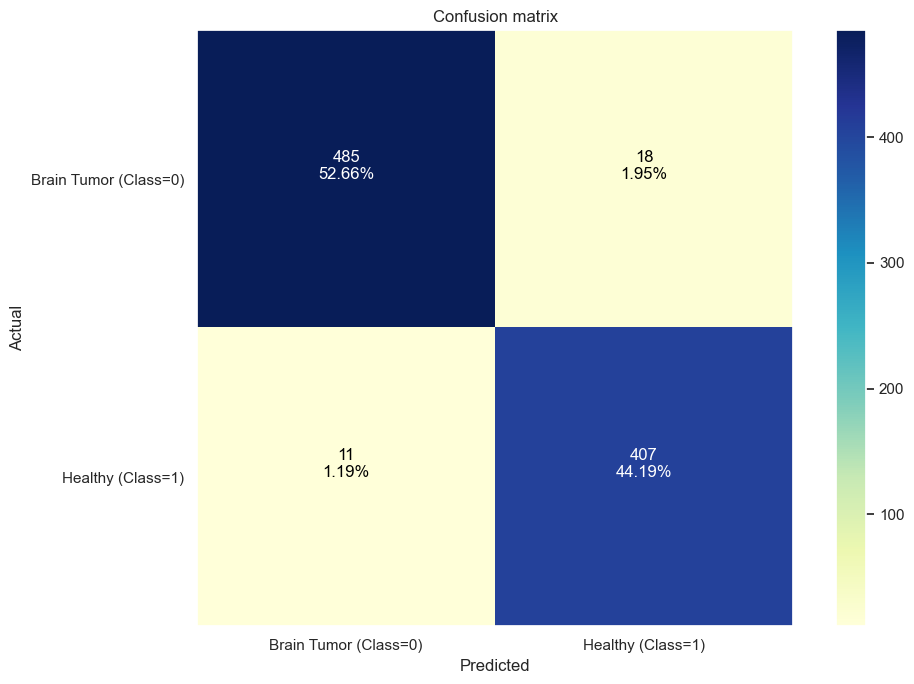

In [32]:
# Confusion Matrix Plotting Function
def show_confusion_matrix(cm, CLA_label, title='Confusion matrix', cmap=plt.cm.YlGnBu):
    
    plt.figure(figsize=(10,7))
    plt.grid(False)
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(CLA_label))

    plt.xticks(tick_marks, [f"{value} (Class={key})" for key , value in CLA_label.items()], rotation=0)
    plt.yticks(tick_marks, [f"{value} (Class={key})" for key , value in CLA_label.items()])

    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, f"{cm[i,j]}\n{cm[i,j]/np.sum(cm)*100:.2f}%", horizontalalignment="center", color="white" if cm[i, j] > thresh else "black")

    plt.ylabel('Actual')
    plt.xlabel('Predicted')
    plt.tight_layout()
    plt.show()

show_confusion_matrix(cm, CLA_label)

**Code explanation**

1. Function Definition: `True_and_Pred()`

2. Inside the function:

```python
i = 0
y_true = []
y_pred = []
```

3. Initialize lists to store:

  * `y_true`: actual labels
  * `y_pred`: predicted labels

4. Loop through validation set:

```python
for images, labels in val_loader:
    images = images.to(device)
    labels = labels.numpy()
```

* Moves image batch to the computation device (GPU or CPU).
* Converts labels to NumPy arrays for later processing.

5. Get predictions from the model:

```python
outputs = model(images)
_, pred = torch.max(outputs.data, 1)
pred = pred.detach().cpu().numpy()
```

* `outputs = model(images)`: forward pass through the CNN.
* `torch.max(outputs.data, 1)`:

  * Finds the index of the class with the **highest predicted log-probability**.
* `.detach().cpu().numpy()`: moves tensor to CPU and converts to NumPy array.

6. Append true and predicted labels:

```python
y_true = np.append(y_true, labels)
y_pred = np.append(y_pred, pred)
```

* Builds up `y_true` and `y_pred` lists over all validation batches.

7. Return collected labels:

```python
return y_true, y_pred
```
8. Run the function and generate reports:

```python
y_true, y_pred = Ture_and_Pred(val_loader, cnn_model)
```

9. Generate confusion matrix:

```python
cm = confusion_matrix(y_true, y_pred)
```

* Creates a **confusion matrix** using scikit-learn.
* Helps identify specific kinds of **misclassifications** (e.g., tumor labeled as healthy or vice versa).

## Save Model

In [28]:
torch.save(cnn_model, "Brain_Tumor_model.pt")